<a href="https://colab.research.google.com/github/alyssapalms/Assignment15/blob/main/Assignment15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import shap


sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

Load dataset

In [5]:
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded['bank-loan.csv']))

print("Upload successful! Here are the first rows:")
df.head()

Saving bank-loan.csv to bank-loan.csv
Upload successful! Here are the first rows:


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


#Task 1 - Data Analysis and Cleaning

Summary Statistics:
              age          ed      employ     address      income     debtinc  \
count  850.000000  850.000000  850.000000  850.000000  850.000000  850.000000   
mean    35.029412    1.710588    8.565882    8.371765   46.675294   10.171647   
std      8.041432    0.927784    6.777884    6.895016   38.543054    6.719441   
min     20.000000    1.000000    0.000000    0.000000   13.000000    0.100000   
25%     29.000000    1.000000    3.000000    3.000000   24.000000    5.100000   
50%     34.000000    1.000000    7.000000    7.000000   35.000000    8.700000   
75%     41.000000    2.000000   13.000000   12.000000   55.750000   13.800000   
max     56.000000    5.000000   33.000000   34.000000  446.000000   41.300000   

         creddebt     othdebt     default  
count  850.000000  850.000000  700.000000  
mean     1.576805    3.078789    0.261429  
std      2.125840    3.398803    0.439727  
min      0.011696    0.045584    0.000000  
25%      0.382176    1.045942 

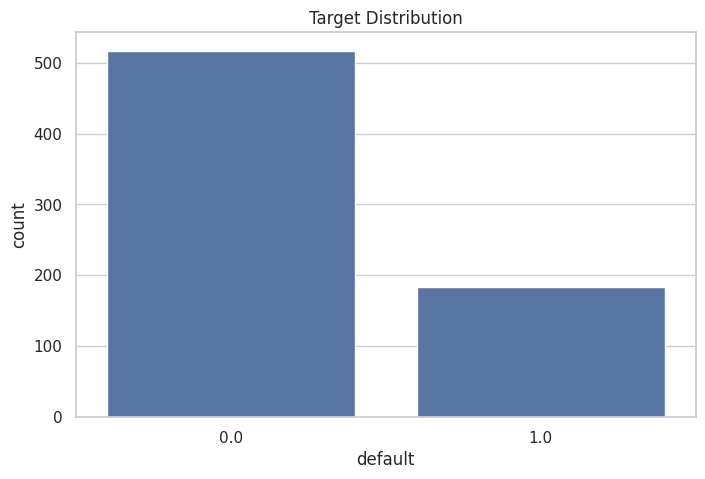

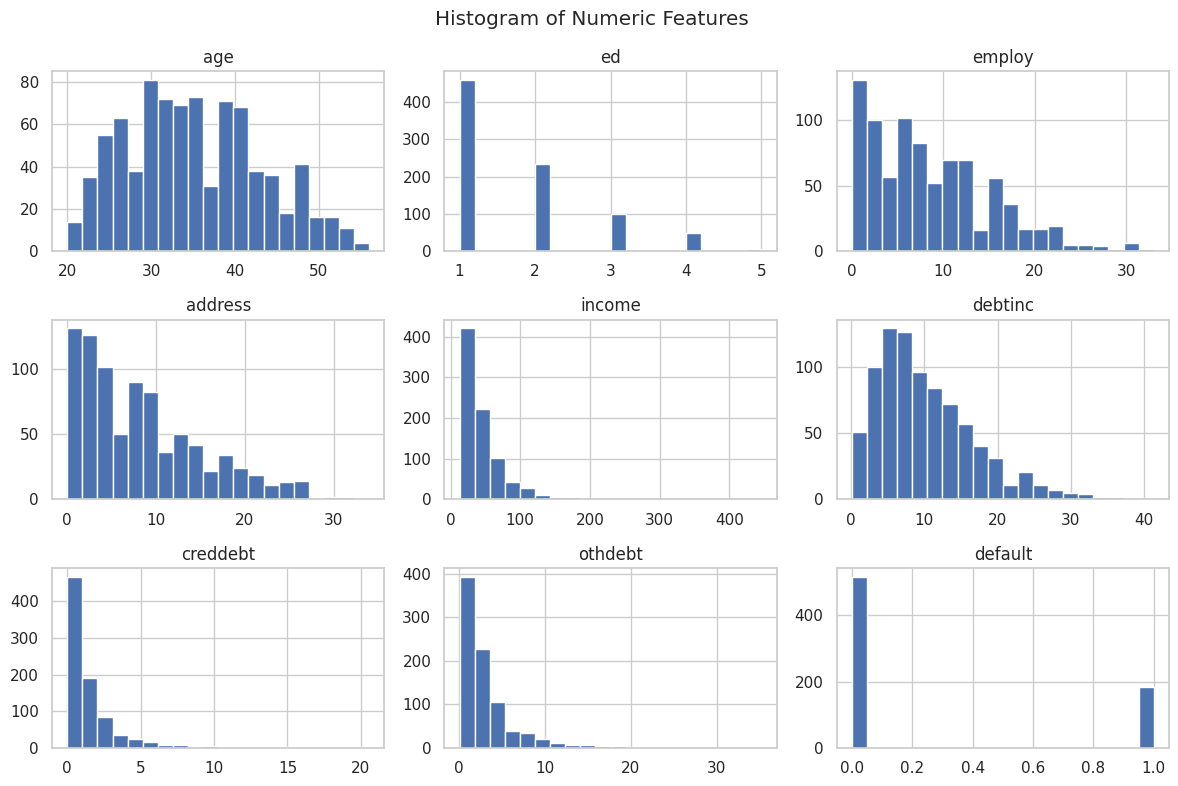

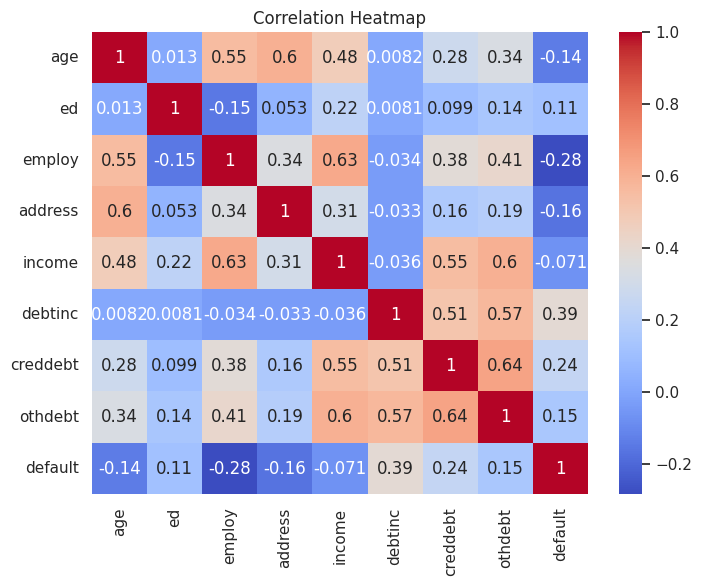


Missing values before cleaning:
age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     150
dtype: int64

Missing values after cleaning:
age         0
ed          0
employ      0
address     0
income      0
debtinc     0
creddebt    0
othdebt     0
default     0
dtype: int64


/tmp/ipython-input-780313926.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [6]:
# 1.1 Summary Statistics
print("Summary Statistics:")
print(df.describe())

# 1.2 Visualizations (EDA)

# Target distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
sns.countplot(x="default", data=df)
plt.title("Target Distribution")
plt.show()

# Histograms of numeric columns
numeric_cols = df.select_dtypes(include=[int, float]).columns
df[numeric_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle("Histogram of Numeric Features")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 1.3 Missing Values
print("\nMissing values before cleaning:")
print(df.isna().sum())

# Fill numeric missing values with median
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

print("\nMissing values after cleaning:")
print(df.isna().sum())

#Task 2 - Feature Engineering and Scaling

In [7]:
# 2.1 Create Age Groups for Fairness
df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 30, 50, 100],
    labels=["Young", "Middle", "Senior"]
)

print("Age group distribution:")
print(df["age_group"].value_counts())


# 2.2 Train-Test Split
from sklearn.model_selection import train_test_split

X = df.drop(["default", "age_group"], axis=1)
y = df["default"]
groups = df["age_group"]

X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


# 2.3 Feature Engineering (same style as your lab)
# Create one simple engineered feature
X_train["total_debt"] = X_train["creddebt"] + X_train["othdebt"]
X_test["total_debt"] = X_test["creddebt"] + X_test["othdebt"]

print("Engineered feature 'total_debt' added.")


# 2.4 Scaling Numerical Features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_cols = X_train.columns

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Scaling completed.")

Age group distribution:
age_group
Middle    533
Young     286
Senior     31
Name: count, dtype: int64
Train shape: (680, 8)
Test shape: (170, 8)
Engineered feature 'total_debt' added.
Scaling completed.


#Task 3 - Model Building

Model training complete.

Accuracy: 0.8

Confusion Matrix:
 [[124   9]
 [ 25  12]]


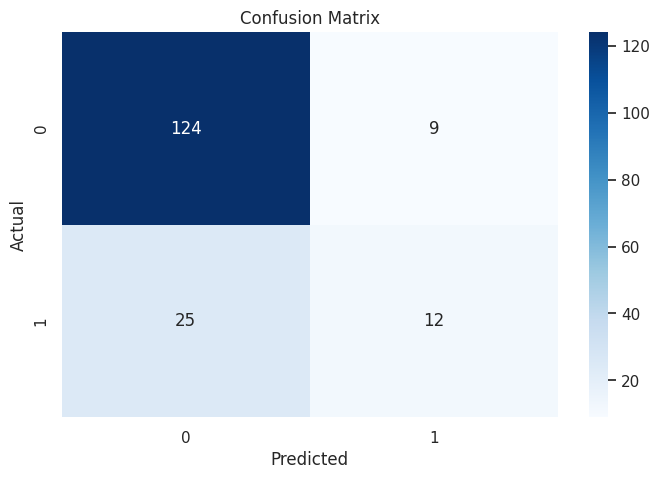


Classification Report:

              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88       133
         1.0       0.57      0.32      0.41        37

    accuracy                           0.80       170
   macro avg       0.70      0.63      0.65       170
weighted avg       0.78      0.80      0.78       170


Top 10 Most Important Features:
1. debtinc: 0.1841
2. employ: 0.1425
3. creddebt: 0.1379
4. total_debt: 0.1190
5. othdebt: 0.1068
6. age: 0.0963
7. income: 0.0914
8. address: 0.0815
9. ed: 0.0405


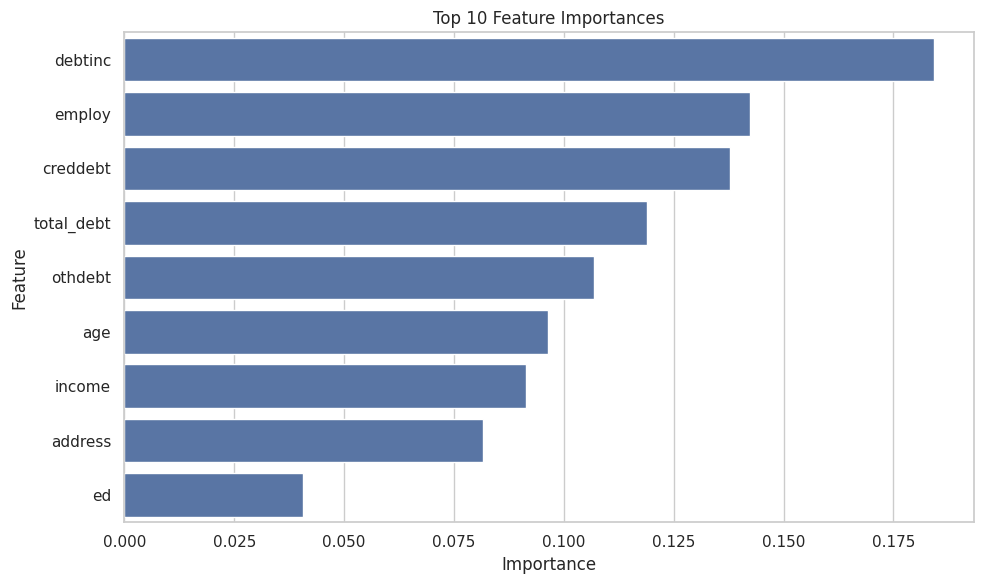

In [8]:
# 3.1 Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Model training complete.")


# 3.2 Predictions
y_pred = model.predict(X_test)


# 3.3 Evaluation Metrics

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", round(accuracy, 4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


# 3.4 Feature Importance

importances = model.feature_importances_
features = X_train.columns

# Sort by importance
sorted_idx = importances.argsort()[::-1]
features_sorted = features[sorted_idx]
importances_sorted = importances[sorted_idx]

print("\nTop 10 Most Important Features:")
for i in range(min(10, len(features_sorted))):
    print(f"{i+1}. {features_sorted[i]}: {importances_sorted[i]:.4f}")

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importances_sorted[:10],
    y=features_sorted[:10]
)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#Task 4 - Explainability and Fairness

Generating SHAP summary plot...


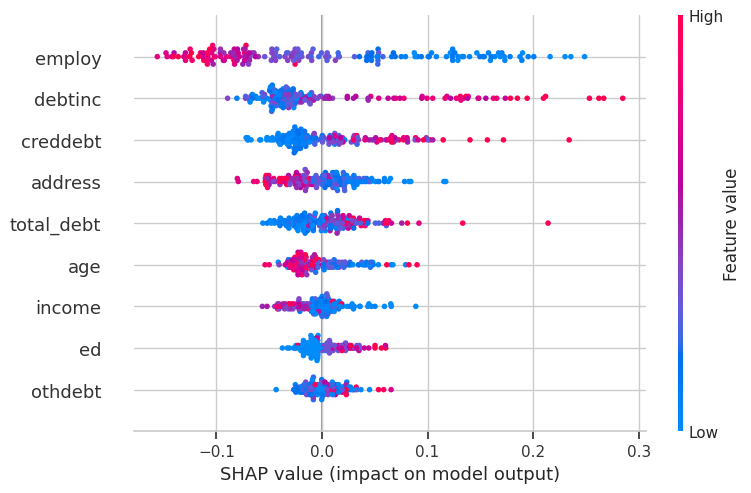


Fairness Analysis by Age Group:
Middle: Accuracy = 0.8333  (Samples = 114)
Young: Accuracy = 0.7255  (Samples = 51)
Senior: Accuracy = 0.8000  (Samples = 5)


In [15]:
import shap
import numpy as np

X_test_sample = X_test.sample(min(200, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(model, X_train)

shap_values = explainer(X_test_sample, check_additivity=False)

shap_values_class1 = shap_values.values[:,:,1] if shap_values.values.ndim == 3 else shap_values.values

print("Generating SHAP summary plot...")
shap.summary_plot(
    shap_values_class1,
    X_test_sample,
    feature_names=X_test_sample.columns
)

# 4.2 Fairness Analysis by Age Group

from sklearn.metrics import accuracy_score
import pandas as pd

print("\nFairness Analysis by Age Group:")

groups_test = groups_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred)

for group in groups_test.unique():
    mask = (groups_test == group)
    group_accuracy = accuracy_score(y_test_reset[mask], y_pred_reset[mask])
    print(f"{group}: Accuracy = {group_accuracy:.4f}  (Samples = {mask.sum()})")